#  <font color='red'>Table of Contents</font>


[12. Baseline MLP (Colab)](#section12)<br>


In [21]:
#ref - https://stackoverflow.com/questions/14463277/how-to-disable-python-warnings

# Basic Libs..
import warnings
warnings.filterwarnings("ignore")
import math
import time
import pandas as pd
import numpy as np
import scipy
import scipy.sparse
from tqdm import tqdm,tqdm_notebook
from prettytable import PrettyTable
import pickle
from IPython.display import Image
from contextlib import contextmanager
import os
print('CWD is ',os.getcwd())

# Vis Libs..
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text Libs..
import re
from gensim import corpora, models
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer

# ML Libs...
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder,FunctionTransformer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
from sklearn.feature_selection import SelectKBest,f_regression
from sklearn.model_selection import GridSearchCV


# DL Libs..
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input , Dropout, Flatten,concatenate,LSTM
from tensorflow.keras.layers import Embedding
import tensorflow.keras
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint,TensorBoard,ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

# Colab Libs...
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

CWD is  /content/gdrive/My Drive/Mercari2


#  <a id = 'section12'> <font color='red'>  12. Baseline MLP (colab)  </font> </a>

### <font color='red'> 12.1 Setup Colab Environment </font>

In [ ]:
'''
Code below sets up Google Colab to load the input files from
Google Drive and can output files as well
'''

In [0]:
# Importing Libraries
#ref - https://buomsoo-kim.github.io/colab/2018/04/16/Importing-files-from-Google-Drive-in-Google-Colab.md/

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
import os
os.chdir('/content/gdrive/My Drive/Mercari2')
print("We are currently in the folder of ",os.getcwd())

We are currently in the folder of  /content/gdrive/My Drive/Mercari2


### <font color='red'> 12.2 Load Data From GDrive </font>

In [5]:
file = open('df_train_model', 'rb')
df_train_model = pickle.load(file)
file.close()

file = open('df_test_model', 'rb')
df_test_model = pickle.load(file)
file.close()

print(df_train_model.shape,df_test_model.shape)

(1111901, 8) (370634, 8)


In [6]:
# ref - https://www.kaggle.com/valkling/mercari-rnn-2ridge-models-with-notes-0-42755

df_train_model = df_train_model[(df_train_model.price >= 3) & (df_train_model.price <= 2000)]
print(df_train_model.shape)

(1111222, 8)


### <font color='red'> 12.3 Encoding Data </font>

In [0]:
# ref - https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
'''
This Function concatenates text features from item-name,brand,category,description to create 
the concatenated text feature.
'''

def data_preprocess(df):
    df['name'] = df['name'].fillna('') + ' ' + df['brand_name'].fillna('')
    df['text'] = (df['item_description'].fillna('') + ' ' + df['name'] + ' ' + df['category_name'].fillna(''))
    return df[['name', 'text', 'shipping', 'item_condition_id','price']]

In [0]:
'''
This Function takes in train,test datasets as input and returns 
feature transforms - Tfidfvectorizer,Onehotencoder,etc. and 
returns concatenated feature (hstack) of X_train,X_test,y_train,y_test as output.
'''
def data_encoder(train,test):
    # Text Encoding for Names...
    vect_name = TfidfVectorizer(max_features=100000, token_pattern='\w+', dtype=np.float32)
    train_name  = vect_name.fit_transform(train['name'].values)
    test_name = vect_name.transform(test['name'].values)

    # Text Encoding for Text...
    vect_text = TfidfVectorizer(max_features=100000, token_pattern='\w+', ngram_range=(1, 2), dtype=np.float32)
    train_text  = vect_text.fit_transform(train['text'].values)
    test_text = vect_text.transform(test['text'].values)

    # Encoding for Shipping, Item Condition ID...
    train_dummies = scipy.sparse.csr_matrix(pd.get_dummies(train[["item_condition_id", "shipping"]], sparse = True).values)
    test_dummies = scipy.sparse.csr_matrix(pd.get_dummies(test[["item_condition_id", "shipping"]], sparse = True).values)

    # Final Feature Stack for X_train,X_test
    X_train = scipy.sparse.hstack((train_name, train_text, train_dummies)).tocsr().astype('float32')
    X_test = scipy.sparse.hstack((test_name, test_text, test_dummies)).tocsr().astype('float32')

    # Final Outputs.. y_train,y_test (Standardizing the output variable price) using standardscaler...
    global y_scaler
    y_scaler = StandardScaler()
    y_train = y_scaler.fit_transform(np.log1p(train['price'].values.reshape(-1, 1)))
    y_test = y_scaler.transform(np.log1p(test['price'].values.reshape(-1, 1)))

    return X_train,X_test,y_train,y_test

In [47]:
X_train,X_test,y_train,y_test = data_encoder(data_preprocess(df_train_model),data_preprocess(df_test_model))
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(1111222, 190546) (370634, 190546) (1111222, 1) (370634, 1)


### <font color='red'> 12.4 Creating MLP Model </font>

In [0]:
'''Building a Sparse MLP model'''

def build_mlp_model(train):
    model_in = Input(shape=(train.shape[1],), dtype='float32', sparse=True)
    out = Dense(256, activation='relu')(model_in)
    out = Dense(64, activation='relu')(out)
    out = Dense(64, activation='relu')(out)
    out = Dense(32, activation='relu')(out)
    out = Dense(1)(out)
    model = Model(model_in, out)
    return model

In [51]:
'''Summarizing the model built'''

baseline_mlp_model = build_mlp_model(X_train)
baseline_mlp_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 190546)]          0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               48780032  
_________________________________________________________________
dense_6 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_7 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_8 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 33        
Total params: 48,802,753
Trainable params: 48,802,753
Non-trainable params: 0
_______________________________________________

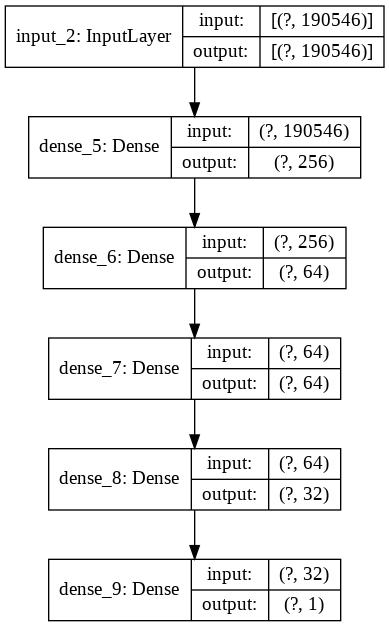

In [52]:
'''Graphical Visualization of the Model'''

plot_model(baseline_mlp_model, to_file='baseline_mlp_model.png', show_shapes=True, show_layer_names=True)
Image(filename='baseline_mlp_model.png')

### <font color='red'> 12.5 Train Model </font>

In [0]:
# ref - https://www.kaggle.com/lopuhin/mercari-golf-0-3875-cv-in-75-loc-1900-s
'''This function builds a timer which prints time elapsed for a code section to execute'''

@contextmanager
def timer(name):
    t0 = time.time()
    yield
    print(f'[{name}] done in {time.time() - t0:.0f} s')

In [0]:
'''Defining the Evaluation Metric - RMSLE'''

def rmsle_score(y, y_pred):
    assert len(y) == len(y_pred)
    to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
    return (sum(to_sum) * (1.0/len(y))) ** 0.5

In [56]:
'''Training Model'''

baseline_mlp_model.compile(loss='mean_squared_error', optimizer=optimizers.Adam(lr=3e-3))
filepath = "baseline_mlp_model_epochs:{epoch:03d}-val_loss:{val_loss:.3f}.hdf5"
checkpoint = ModelCheckpoint(filepath,monitor="val_loss",mode="min",save_best_only = True,verbose = 1)
tensorboard = TensorBoard(log_dir='/content/gdrive/My Drive/Mercari2/log_baseline_mlp_model')
callbacks_list = [checkpoint,tensorboard]

# Training 3 Models with incremental Batch Sizes of (256,512,1024,2049) for 1 epoch each..
for i in range(4):
    with timer(f'epoch {i + 1}'):
        baseline_mlp_model.fit(x=X_train, y=y_train, batch_size=2**(8 + i), epochs=1, verbose=1, validation_data=(X_test, y_test),callbacks = callbacks_list)
        # print('Test RMSLE after epoch = ',i,' is ',rmsle_score(np.expm1(y_test) , np.expm1(baseline_mlp_model.predict(X_test)[:, 0])),'\n')
    
        preds = baseline_mlp_model.predict(X_test)[:, 0]
        y_pred = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])
        print('Test RMSLE for batch size = ',2**(8 + i),' is ',rmsle_score(df_test_model.price.values , y_pred),'\n')

4340/4341 [============================>.] - ETA: 0s - loss: 0.2883
Epoch 00001: val_loss improved from inf to 0.32293, saving model to baseline_mlp_model_epochs:001-val_loss:0.323.hdf5
4341/4341 [==============================] - 100s 23ms/step - loss: 0.2883 - val_loss: 0.3229
Test RMSLE for batch size =  256  is  0.4242432088221895 

[epoch 1] done in 120 s
2171/2171 [==============================] - ETA: 0s - loss: 0.1804
Epoch 00001: val_loss improved from 0.32293 to 0.31812, saving model to baseline_mlp_model_epochs:001-val_loss:0.318.hdf5
2171/2171 [==============================] - 58s 27ms/step - loss: 0.1804 - val_loss: 0.3181
Test RMSLE for batch size =  512  is  0.4210777707203211 

[epoch 2] done in 79 s
1086/1086 [==============================] - ETA: 0s - loss: 0.1081
Epoch 00001: val_loss improved from 0.31812 to 0.31722, saving model to baseline_mlp_model_epochs:001-val_loss:0.317.hdf5
1086/1086 [==============================] - 37s 34ms/step - loss: 0.1081 - val_lo

##### Results - Model with batch size = 512 gave the best results 

### <font color='red'> 12.6 Test Model </font>


In [57]:
best_model = load_model('/content/gdrive/My Drive/Mercari2/baseline_mlp_model_epochs:001-val_loss:0.317.hdf5')

preds = best_model.predict(X_test)[:, 0]
y_pred = np.expm1(y_scaler.inverse_transform(preds.reshape(-1, 1))[:, 0])

print('RMSLE of Test set is ',rmsle_score(df_test_model.price.values , y_pred))

RMSLE of Test set is  0.42047725006422204


##### Summary - We obtain a Test RMSLE of 0.42, the best Model so far obtained